In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

In [215]:
# combine the gsets
p1 = np.load('./raw_data/genesets/BioCarta_2016.npy', allow_pickle=True).item()
p2 = np.load('./raw_data/genesets/GO_Biological_Process_2023.npy', allow_pickle=True).item()
p3 = np.load('./raw_data/genesets/HumanCyc_2016.npy', allow_pickle=True).item()
p4 = np.load('./raw_data/genesets/KEGG_2021_Human.npy', allow_pickle=True).item()
p5 = np.load('./raw_data/genesets/Reactome_2022.npy', allow_pickle=True).item()
p6 = np.load('./raw_data/genesets/WikiPathways_2019_Human.npy', allow_pickle=True).item()
res = {**p1, **p2, **p3, **p4, **p5, **p6}
np.save('./processed_data/genesets/all_paths.npy', res)

In [333]:
pd.DataFrame.from_dict(res, orient='index').to_csv('./processed_data/genesets/all_paths.csv')

In [2]:
# get pathway gene matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')

In [581]:
leading_edge = pd.read_csv( './processed_data/for_plotting/leading_edge_EX.csv', index_col=0)
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)

In [408]:
P = set(fgsea[fgsea['x']=='Ex']['pathway'])

In [585]:
expression = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
S = set(np.array(expression.index[np.abs(expression['Ex'])>1]))

In [586]:
S = set(leading_edge['gene'][[x in S for x in leading_edge['gene']]])

In [587]:
#S = set(leading_edge['gene'])
len(S)

244

In [597]:
col_index = np.where([x in S for x in mat.columns])[0]
mat_sub = mat.iloc[:,col_index]
#path_index = np.where([x in P for x in mat_sub.index])[0]
#mat_sub = mat_sub.iloc[path_index]
path_index = (np.sum(mat_sub, axis=1)>7)
mat_sub = mat_sub.loc[path_index]

mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]


In [598]:
mat_sub.shape

(276, 237)

In [589]:
np.sum(mat_sub.shape)/70

52.92857142857143

In [599]:
# assign the clusters

C = 0
KL_modified = True
random_labels = True
unweighted = True

frame, loss_temp = get_kernighan_lin_clusters(None, 100, C, KL_modified, random_labels, unweighted, seed=5, no_progress=False, mat=mat_sub)
frame.columns = ['cluster', 'description', 'is_gene']

3it [00:00,  3.19it/s, tot_impr=1958, last_impr=0, loss=1810]   


In [600]:
cols = np.array(frame['cluster'][frame['is_gene']])
g_names  = np.array(frame['description'][frame['is_gene']])
rows = np.array(frame['cluster'][np.invert(frame['is_gene'])])
p_names  = np.array(frame['description'][np.invert(frame['is_gene'])])

matrix = np.array(mat_sub)

  # set up the graph
N = len(rows) + len(cols)
full_matrix = np.zeros((N, N), dtype=matrix.dtype)
full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
graph = networkx.from_numpy_array(full_matrix)
cluster_labels = np.concatenate([rows, cols])
node_names = np.concatenate([p_names, g_names])
for i, l in enumerate(cluster_labels):
    graph.nodes[i]['cluster_id'] = l
    graph.nodes[i]['type'] = i < matrix.shape[0]
    graph.nodes[i]['name'] = node_names[i]

for e_i in range(N):
    for e_j in range(e_i + 1, N):
        if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
            graph.add_edge(e_i, e_j, weight=0.05)

components = list(networkx.connected_components(graph))
unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))


In [601]:
unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

cur_labels = np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes])
layout = networkx.spring_layout(graph,k=10, iterations=10, weight='weight')

/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/1660747507.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


In [602]:
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)

In [575]:
def plot_edges(layout, graph, pos):
    for e_from, e_to in list(graph.edges):
        ss = np.array([layout[e_from], layout[e_to]])
        if graph.get_edge_data(e_from, e_to)['weight'] >=0.5:
            plt.plot(*(ss.T), c='black', alpha=0.1)
        
def plot_nodes(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        if np.sum(index)==0:
            continue
        plot_single_cluster(colors[i], pos[index], types[index], names[index], cluster_name, selected_names, S)

def plot_nodes_continuous(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, score in enumerate(cur_labels):
        plt.scatter(pos[i][0], pos[i][1], color=colors[i], zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)

        
def plot_single_cluster(col, pos_curr, types_curr, names_curr, cluster_name, selected_names, S):
    props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=col)
    x, y = np.mean(pos_curr, axis = 0)
    x-=0.2
    plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
    plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')
    
    labels = ''
    n=0
    
    for i, name in enumerate(names_curr):
        if name in selected_names:
            #labels+='\n'+name
            #n+=1
            plt.text(pos_curr[i,0], pos_curr[i,1], name,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
            
    #plt.text(x, y, labels,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
    plt.text(x, y+(0.045*(n+1)), cluster_name,  bbox=props, c = col, fontsize = 15, zorder=6, weight = "bold")


/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/737365590.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/737365590.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


(-1.0985222160816193,
 1.0689665377140045,
 -1.0787650644779205,
 1.0920688211917877)

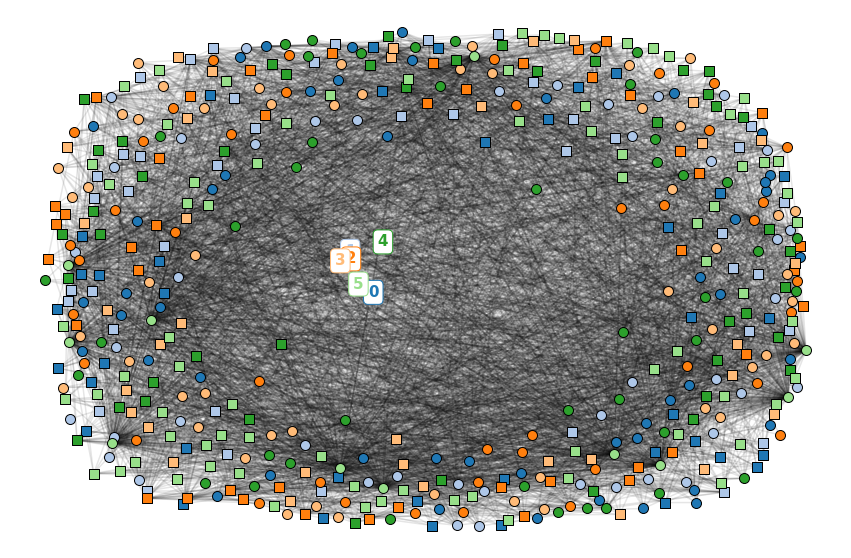

In [603]:
plt.figure(figsize = (15,10))

# plot by cluster color
pos = np.array(list(layout.values()))
np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
plot_edges(layout, graph, pos)
plot_nodes(graph, [], pos, cur_labels, unique_clusters, colors, 100)
a = plt.gca()
a.axis('off')
#plt.savefig('./pdf_figures/LE_clust_ex.png')

In [604]:
SCORES = np.array(scores.loc[g_names]['Ex'])

Text(0.5, 0, 'Gene Cluster')

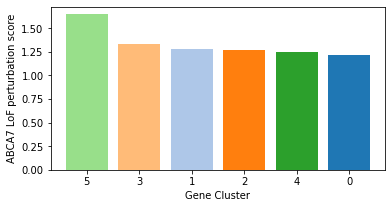

In [605]:
#barplot of main scores
score_sum = np.array([np.median(np.abs(SCORES[frame['cluster'][frame['is_gene']]==i])) for i in unique_clusters])
plt.figure(figsize = (6,3))

plt.bar(height=score_sum[np.argsort(-1*score_sum)], x = [x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]], color = np.array(colors)[np.argsort(-1*score_sum)])
plt.ylabel('ABCA7 LoF perturbation score')
plt.xlabel('Gene Cluster')
#plt.savefig('./pdf_figures/ex_clust_bars.png', bbox_inches="tight")

In [488]:
# SCORES = np.array(scores.loc[g_names]['Ex'])
# COL = 'PuOr_r'#C2[i]
# cm = plt.cm.get_cmap(COL, len(SCORES))
# colors = [cm(int(x)) for x in range(len(SCORES))]
# colors = list(np.array(colors))#[np.argsort(SCORES)])

# plt.figure(figsize = (15,10))

# index = np.where(np.invert([graph.nodes[x]['type'] for x in graph.nodes]))[0]
# graph_sub = graph.subgraph(list(index))

# plt.scatter(pos[index,0], pos[index,1], c=SCORES.reshape(-1,1), zorder=5, s=200, cmap='PuOr_r', edgecolor="black", linewidth=1)
# plt.clim(-1.5,1.5)
# #plt.text(pos[index,0][np.argmin(SCORES)], pos[index,1][np.argmin(SCORES)], g_names[np.argmin(SCORES)])
# #plt.colorbar()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# a = plt.gca()
# a.axis('off')
# plt.savefig('./pdf_figures/LE_clust_ex_scores.png')

In [491]:
def get_representative_name_per_cluster(bipartite_mat, colnames_mat, rownames_mat, description_table, cluster):
    genes = set(description_table.loc[description_table['is_gene']&(description_table['cluster']==cluster)]['description'])
    paths = set(description_table.loc[np.invert(description_table['is_gene'])&(description_table['cluster']==cluster)]['description'])
    if len(paths)==0:
        return 'C.'+str(cluster), np.nan, np.nan, np.nan
    else:
        index_col = [x in genes for x in colnames_mat]
        index_row = [x in paths for x in rownames_mat]
        
        #ipdb.set_trace()
    
        sum_internal = np.sum(bipartite_mat[index_row][:,index_col], axis=1)
        sum_external = np.sum(bipartite_mat[index_row][:,np.invert(index_col)], axis=1)
        sum_ratio = sum_internal/(sum_external+sum_internal)
        S = np.argsort(-1*sum_internal)[:10]
        rep_name = rownames_mat[index_row][S]

        return rep_name #'C.'+str(cluster), rep_name.split(' (')[0], sum_internal[S], sum_internal[S]
    

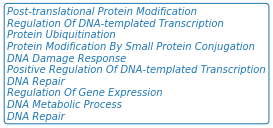

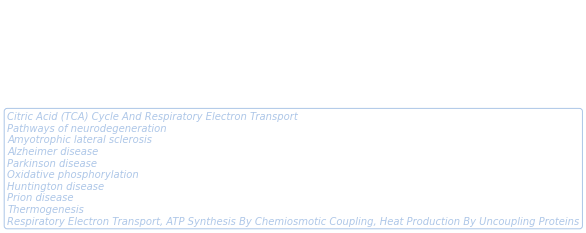

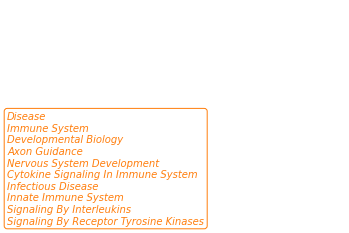

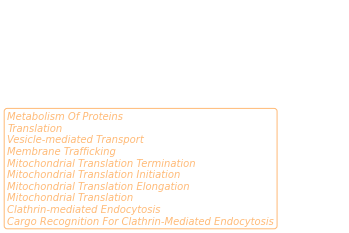

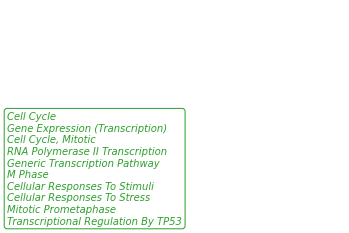

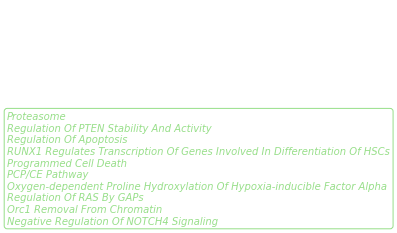

<Figure size 432x288 with 0 Axes>

In [606]:
# get rep names
colnames = np.array(mat_sub.columns)
rownames = np.array(mat_sub.index)

out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, x) for x in np.unique(frame['cluster'])]


import re
from adjustText import adjust_text

plt.figure(figsize = (1,1))
a = plt.gca()
a.axis('off')
#plot_edges(layout, graph, pos)
texts = []
y = 0
for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        x, y = np.mean(pos[index], axis=0)
        
        props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
        temp = [re.split(r' [(]GO| R-',x)[0] for x in out[i]]
        T = ('\n').join(temp)
        plt.text(0, 0, T,  bbox=props, c =colors[i], fontsize = 10, style = "italic")
        
        a = plt.gca()
        a.axis('off')
        #plt.savefig('./pdf_figures/LE_clust_ex_names' + str(i) + '.png', bbox_inches="tight")
        plt.figure()
        #y+=0.01
        
#adjust_text(texts)
    



In [ ]:
### mention specific go pathways (lipid-related ones etc)
### show gene and pathway directions (better scoring) for sub-clusters
### keep KL results stringent; say something like; when relax the cutoff, see additional processes, like lipids
### then show targeted lipid analysis after lipidomics

#### Subclustering 1

In [637]:
# assign the clusters
# 0
# 9

mat_sub2 = (mat_sub.loc[np.array(frame['cluster']==3)[np.invert(frame['is_gene'])],np.array(frame['cluster']==3)[frame['is_gene']]])

frame2, loss_temp = get_kernighan_lin_clusters(None, 25, C, KL_modified, random_labels, unweighted, seed=5, no_progress=False, mat=mat_sub2)
frame2.columns = ['cluster', 'description', 'is_gene']

3it [00:00, 113.29it/s, tot_impr=145, last_impr=0, loss=74]


In [630]:
mat_sub2.shape

(44, 42)

In [638]:
cols = np.array(frame2['cluster'][frame2['is_gene']])
g_names  = np.array(frame2['description'][frame2['is_gene']])
rows = np.array(frame2['cluster'][np.invert(frame2['is_gene'])])
p_names  = np.array(frame2['description'][np.invert(frame2['is_gene'])])

matrix = np.array(mat_sub2)

  # set up the graph
N = len(rows) + len(cols)
full_matrix = np.zeros((N, N), dtype=matrix.dtype)
full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
graph = networkx.from_numpy_array(full_matrix)
cluster_labels = np.concatenate([rows, cols])
node_names = np.concatenate([p_names, g_names])
for i, l in enumerate(cluster_labels):
    graph.nodes[i]['cluster_id'] = l
    graph.nodes[i]['type'] = i < matrix.shape[0]
    graph.nodes[i]['name'] = node_names[i]

for e_i in range(N):
    for e_j in range(e_i + 1, N):
        if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
            graph.add_edge(e_i, e_j, weight=0.05)

components = list(networkx.connected_components(graph))
unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))


In [639]:

cur_labels = np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes])
layout = networkx.spring_layout(graph,k=15, iterations=10000, weight='weight')

In [640]:
# tab20c, 8
# tab20b, 4

unique_clusters = np.unique(frame2['cluster'])
cm = plt.cm.get_cmap('Dark2')
colors = [cm(int(x)) for x in range(len(unique_clusters))]


/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/4251609820.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/737365590.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23603041.0.0/ipykernel_2208768/737365590.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


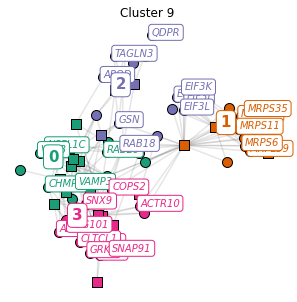

In [641]:
plt.figure(figsize = (5,5))

# plot by cluster color
pos = np.array(list(layout.values()))
#np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
plot_edges(layout, graph, pos)

G = set(scores.index[np.abs(scores['Ex'])>1.3])
SELE = set(mat_sub2.columns[[x in G for x in mat_sub2.columns]])

plot_nodes(graph, SELE, pos, cur_labels, unique_clusters, colors, 100)
a = plt.gca()
plt.title('Cluster 9')
a.axis('off')
plt.savefig('./pdf_figures/9_subcluster.png')

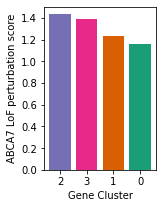

In [642]:
#barplot of main scores
SCORES = np.array(scores.loc[g_names]['Ex'])

score_sum = np.array([np.median(SCORES[frame2['cluster'][frame2['is_gene']]==i]) for i in unique_clusters])
plt.figure(figsize = (2,3))

plt.bar(height=score_sum[np.argsort(-1*score_sum)], x = [x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]], color = np.array(colors)[np.argsort(-1*score_sum)])
plt.ylabel('ABCA7 LoF perturbation score')
plt.xlabel('Gene Cluster')
plt.savefig('./pdf_figures/9_bars.png', bbox_inches="tight")

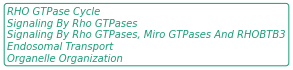

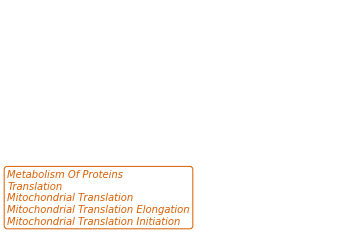

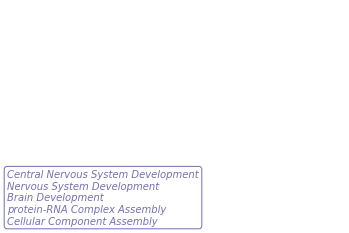

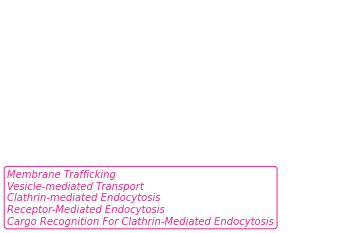

<Figure size 432x288 with 0 Axes>

In [643]:
# get rep names
colnames = np.array(mat_sub2.columns)
rownames = np.array(mat_sub2.index)

out = [get_representative_name_per_cluster(np.array(mat_sub2), colnames, rownames, frame2, x) for x in np.unique(frame2['cluster'])]


import re
from adjustText import adjust_text

plt.figure(figsize = (1,1))
a = plt.gca()
a.axis('off')
#plot_edges(layout, graph, pos)
texts = []
y = 0
for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        x, y = np.mean(pos[index], axis=0)
        
        props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
        temp = [re.split(r' [(]GO| R-',x)[0] for x in out[i][:5]]
        T = ('\n').join(temp)
        plt.text(0, 0, T,  bbox=props, c =colors[i], fontsize = 10, style = "italic")
        
        a = plt.gca()
        a.axis('off')
        plt.savefig('./pdf_figures/9_names_' + str(i) + '.png', bbox_inches="tight")
        plt.figure()
        #y+=0.01
        
#adjust_text(texts)
    

